# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.152315 -0.008257  0.229576 -0.459560 -0.115707 -0.250769   
      201547 -0.429644 -0.180829  0.196399  0.251703  0.151782  0.120646   
      201548 -0.161068  0.576082 -0.324825  0.105533  0.241237  0.022886   
      201549 -0.260170  0.167611 -0.298852  0.011480  0.048733  0.113631   
      201550  0.441330  0.225024  0.025560 -0.678361  0.065666 -0.795079   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.473106 -0.372146 -0.407803  0.184894  ... -0.042693  0.103824   
      201547 -0.128355 -0.304024  0.658483 -0.437008  ...  0.337440  0.368487   
      201548  0.055301 -0.310014 -0.244395  0.053250  ...  0.473314 -0.227580   
      201549 -0.398770 -0.094119  0.217093 -0.104882  ... -0.244155  0.278916   
      201550  0.085061 -0.637887  0.213285  0.176507  ...  0.190214 -0.204953   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.719872 -0.460573 -0.098291 -0.444475  0.310875  0.028429   
      201547  0.962856  0.200345 -0.157422 -0.599799 -0.170341 -0.048648   
      201548 -0.163233 -0.016585  0.391008  0.751067  0.211474  0.279205   
      201549  0.084838  0.005580  0.201473 -0.214119  0.614926 -0.373807   
      201550  0.399984 -0.400370 -0.097594 -0.198839 -0.752909 -0.156427   

                  1023    Labels  
41001 201546  0.028352 -0.861740  
      201547 -0.643602 -0.854589  
      201548 -0.449406 -0.856973  
      201549  0.123735 -0.856973  
      201550  0.308569 -0.823600  

[5 rows x 1025 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.377501  0.058192 -0.121884  0.142221 -0.422123 -0.338568   
      201821  0.425911  0.212401 -0.038819 -0.400261  0.254694 -0.448073   
      201822 -0.069995  0.237755  0.151022 -0.046802  0.012595 -0.410129   
      201823  0.308861  0.156666  0.139823  0.301422 -0.530209 -0.318304   
      201824 -0.443093  0.134781 -0.274972  0.309000 -0.442412 -0.329776   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.301512  0.143935  0.010483  0.500248  ... -0.029254  0.146947   
      201821  0.297020 -0.398212  0.184892  0.256703  ... -0.185262  0.574425   
      201822 -0.120283  0.390381 -0.328007  0.219778  ...  0.016353  0.355244   
      201823  0.175030  0.086659  0.598123  0.222864  ...  0.038252  0.076745   
      201824 -0.570991 -0.178042  0.269263  0.467060  ... -0.186898  0.164587   

                  1017      1018      1019      1020      1021      1022  \
41001 201820  0.280873 -0.205380 -0.113414  0.261075  0.008019  0.469234   
      201821 -0.105878 -0.163842  0.379176 -0.059638  0.031588 -0.087280   
      201822  0.128836  0.114209 -0.419445  0.404360  0.116429 -0.227992   
      201823 -0.530318 -0.053215 -0.268680 -0.174524 -0.212223  0.224780   
      201824  0.198954  0.493463  0.222790  0.380771 -0.155336 -0.109736   

                  1023    Labels  
41001 201820 -0.946334 -0.949940  
      201821 -0.178241 -0.961859  
      201822 -0.065731 -0.940405  
      201823 -0.588565 -0.961859  
      201824  0.158721 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 3073)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 3073)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 3072)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 3072)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 3072)
The test shape is (310, 3072)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 1024)
The test shape is (310, 3, 1024)


# 2. Model

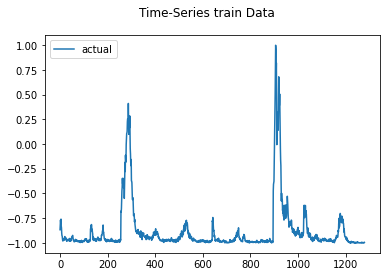

2023-03-08 15:40:00.996340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 15:40:00.996404: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 15:40:00.996447: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-08 15:40:00.996673: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 15:40:03.460190: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 39.326
Test RMSE: 48.827
Test sMAPE: 104.615
Test R Squared: -1.403
{'mae': 39.32561780675765, 'rmse': 48.82655272538618, 'smape': 104.6147092309234, 'r2': -1.4029628725704395}


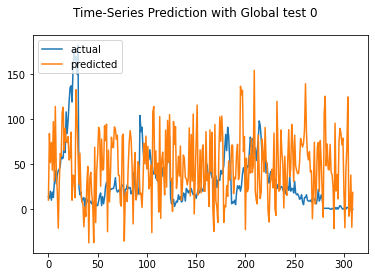

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 38.817
Test RMSE: 48.440
Test sMAPE: 108.052
Test R Squared: -1.365
{'mae': 38.81696283855746, 'rmse': 48.43961469261338, 'smape': 108.0515795065517, 'r2': -1.3650280412298894}


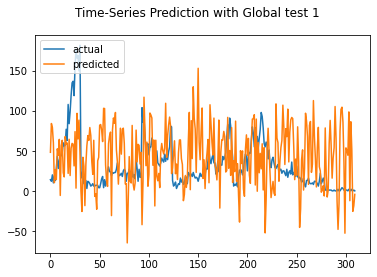

Test MAE: 44.622
Test RMSE: 50.474
Test sMAPE: 100.204
Test R Squared: -1.568
{'mae': 44.62204909170828, 'rmse': 50.473547666350676, 'smape': 100.20352575433333, 'r2': -1.5678082932662676}


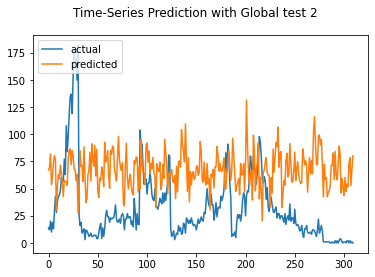

Test MAE: 36.745
Test RMSE: 42.871
Test sMAPE: 91.470
Test R Squared: -0.853
{'mae': 36.744623965601775, 'rmse': 42.87116391596519, 'smape': 91.46996840105588, 'r2': -0.8525309963858598}


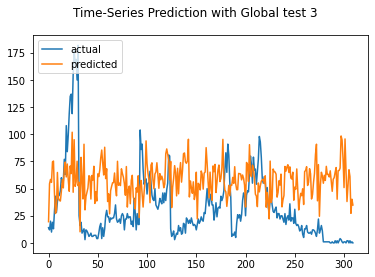

Test MAE: 39.108
Test RMSE: 45.561
Test sMAPE: 94.223
Test R Squared: -1.092
{'mae': 39.10810328452818, 'rmse': 45.56128966323982, 'smape': 94.22295356866772, 'r2': -1.0923144385961439}


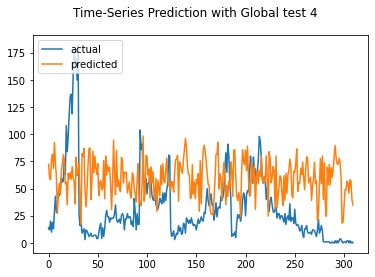

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 36.225
Test RMSE: 43.828
Test sMAPE: 95.125
Test R Squared: -0.936
{'mae': 36.224965949212354, 'rmse': 43.828227167394616, 'smape': 95.12458779714713, 'r2': -0.936166682231095}


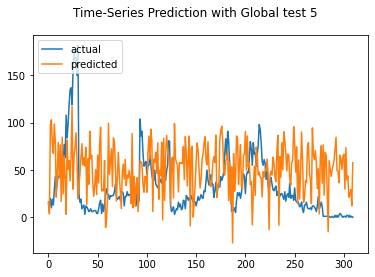

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 41.620
Test RMSE: 50.422
Test sMAPE: 101.623
Test R Squared: -1.563
{'mae': 41.61976571967525, 'rmse': 50.421576105430894, 'smape': 101.62303903374358, 'r2': -1.5625229783074137}


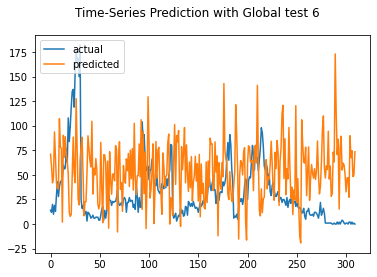

Test MAE: 35.798
Test RMSE: 41.679
Test sMAPE: 91.046
Test R Squared: -0.751
{'mae': 35.79800703294816, 'rmse': 41.67908951978346, 'smape': 91.04639409362909, 'r2': -0.7509404705288991}


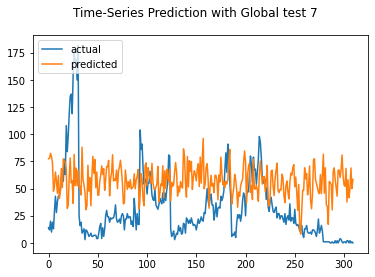

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 33.983
Test RMSE: 44.884
Test sMAPE: 89.362
Test R Squared: -1.031
{'mae': 33.98303477052719, 'rmse': 44.88408600069402, 'smape': 89.36198363307915, 'r2': -1.0305781383067827}


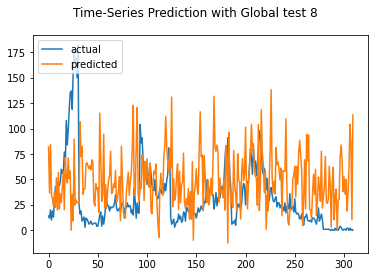

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 37.510
Test RMSE: 49.761
Test sMAPE: 105.307
Test R Squared: -1.496
{'mae': 37.51036918201754, 'rmse': 49.761178447413016, 'smape': 105.30716897973474, 'r2': -1.4958371687990821}


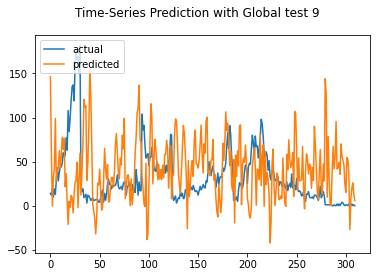

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 42.248
Test RMSE: 51.267
Test sMAPE: 102.011
Test R Squared: -1.649
{'mae': 42.2484161484626, 'rmse': 51.26683810760563, 'smape': 102.01130437050452, 'r2': -1.6491588511945618}


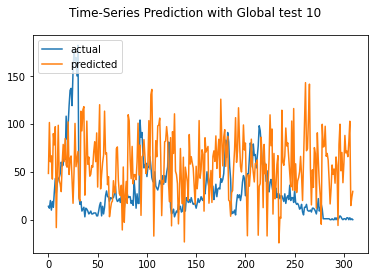

Test MAE: 41.170
Test RMSE: 49.470
Test sMAPE: 95.561
Test R Squared: -1.467
{'mae': 41.170444363932454, 'rmse': 49.47014508729908, 'smape': 95.56074897061274, 'r2': -1.4667282220302882}


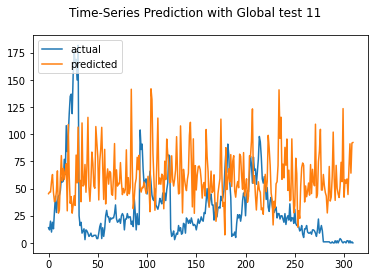

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 38.401
Test RMSE: 46.668
Test sMAPE: 98.477
Test R Squared: -1.195
{'mae': 38.40129768858033, 'rmse': 46.667785693246934, 'smape': 98.47654573393902, 'r2': -1.1951758902707637}


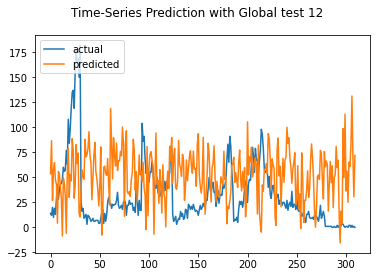

Test MAE: 42.678
Test RMSE: 51.460
Test sMAPE: 96.340
Test R Squared: -1.669
{'mae': 42.67789923510244, 'rmse': 51.45989489106083, 'smape': 96.33977830039336, 'r2': -1.6691484223493274}


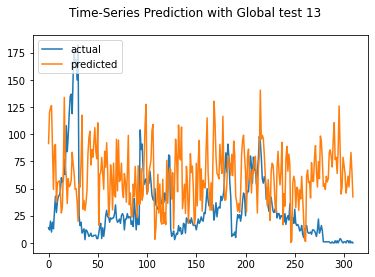

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 36.852
Test RMSE: 45.750
Test sMAPE: 95.230
Test R Squared: -1.110
{'mae': 36.85175832433085, 'rmse': 45.74957642579048, 'smape': 95.23002196911229, 'r2': -1.1096435855545201}


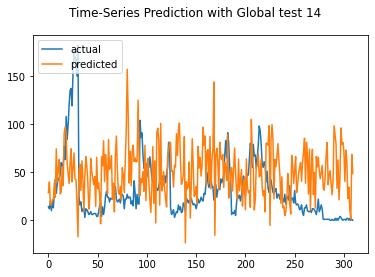

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 36.650
Test RMSE: 48.768
Test sMAPE: 125.600
Test R Squared: -1.397
{'mae': 36.64971434031764, 'rmse': 48.768197671679246, 'smape': 125.6002050996982, 'r2': -1.3972225028456657}


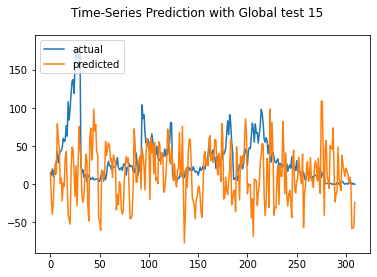

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 33.853
Test RMSE: 42.414
Test sMAPE: 98.242
Test R Squared: -0.813
{'mae': 33.852916403162865, 'rmse': 42.41397456092002, 'smape': 98.24245704675253, 'r2': -0.8132299237719491}


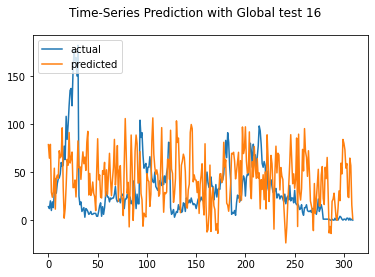

Test MAE: 40.183
Test RMSE: 46.336
Test sMAPE: 96.315
Test R Squared: -1.164
{'mae': 40.183088166290716, 'rmse': 46.33573960064684, 'smape': 96.31475660007916, 'r2': -1.1640492161234839}


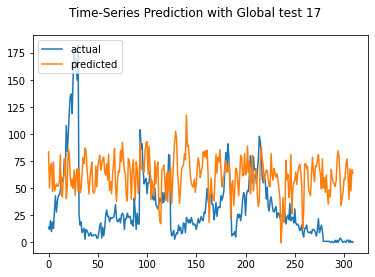

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 35.262
Test RMSE: 43.543
Test sMAPE: 91.963
Test R Squared: -0.911
{'mae': 35.26240744994533, 'rmse': 43.542986544933505, 'smape': 91.96278626505192, 'r2': -0.9110469689086012}


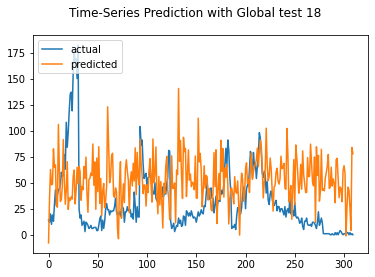

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 36.530
Test RMSE: 46.506
Test sMAPE: 99.421
Test R Squared: -1.180
{'mae': 36.53016442108539, 'rmse': 46.506491831088674, 'smape': 99.42091976892426, 'r2': -1.1800281165291215}


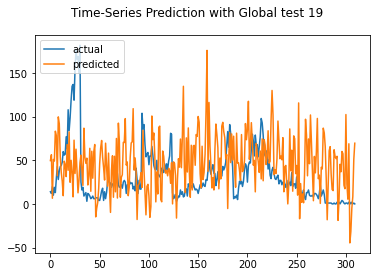

Test MAE: 42.481
Test RMSE: 48.175
Test sMAPE: 97.127
Test R Squared: -1.339
{'mae': 42.48134180499661, 'rmse': 48.17498098224861, 'smape': 97.1269462124934, 'r2': -1.3392575414456354}


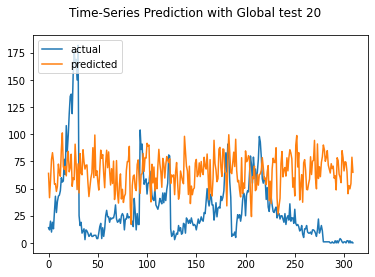

Test MAE: 39.605
Test RMSE: 45.348
Test sMAPE: 96.070
Test R Squared: -1.073
{'mae': 39.60460591719997, 'rmse': 45.34762299117132, 'smape': 96.07017597749153, 'r2': -1.0727359941304746}


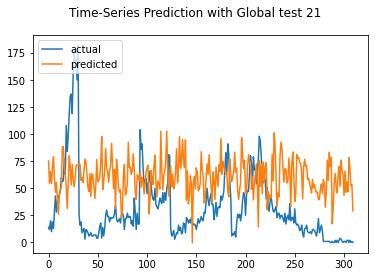

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 46.816
Test RMSE: 58.335
Test sMAPE: 108.570
Test R Squared: -2.430
{'mae': 46.815509678663744, 'rmse': 58.334535102510486, 'smape': 108.57009324342225, 'r2': -2.4299391605451373}


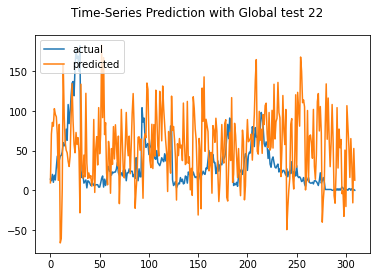

Test MAE: 45.009
Test RMSE: 52.456
Test sMAPE: 101.576
Test R Squared: -1.774
{'mae': 45.00930885268796, 'rmse': 52.45626365882749, 'smape': 101.57619027226939, 'r2': -1.7735093964235609}


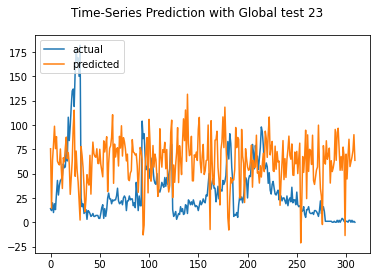

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 34.185
Test RMSE: 44.069
Test sMAPE: 90.435
Test R Squared: -0.957
{'mae': 34.185336308421626, 'rmse': 44.06898782853316, 'smape': 90.43505445737937, 'r2': -0.9574969141027039}


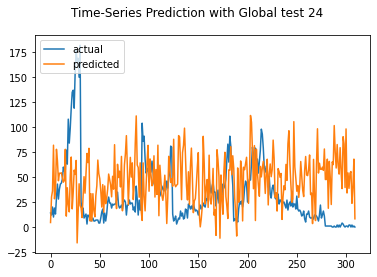

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 33.614
Test RMSE: 42.386
Test sMAPE: 91.243
Test R Squared: -0.811
{'mae': 33.61382163551546, 'rmse': 42.386343075183596, 'smape': 91.24339990835873, 'r2': -0.8108681589427753}


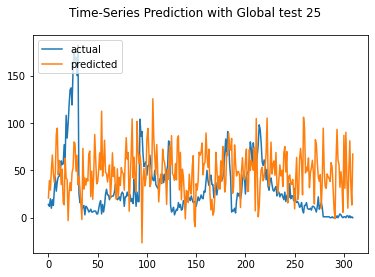

Test MAE: 37.974
Test RMSE: 46.399
Test sMAPE: 91.887
Test R Squared: -1.170
{'mae': 37.97413169799312, 'rmse': 46.39861916059859, 'smape': 91.88702765031877, 'r2': -1.1699266141320197}


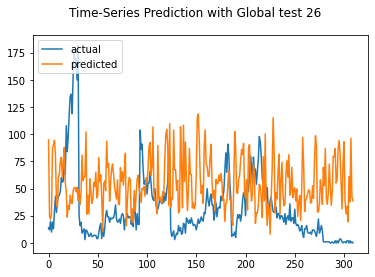

Test MAE: 38.864
Test RMSE: 45.583
Test sMAPE: 95.222
Test R Squared: -1.094
{'mae': 38.864133188801425, 'rmse': 45.58342943522673, 'smape': 95.2220063908548, 'r2': -1.0943483853954081}


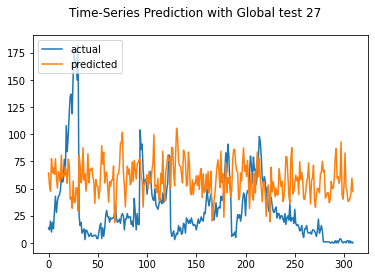

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 49.435
Test RMSE: 56.879
Test sMAPE: 103.427
Test R Squared: -2.261
{'mae': 49.4347262705526, 'rmse': 56.879462058097424, 'smape': 103.42717719438657, 'r2': -2.260963180540505}


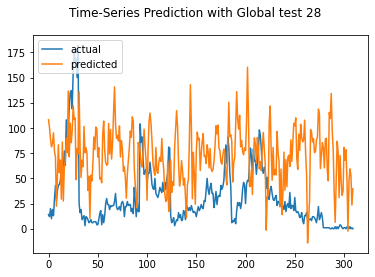

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 33.372
Test RMSE: 42.970
Test sMAPE: 96.579
Test R Squared: -0.861
{'mae': 33.37232989534255, 'rmse': 42.96995638601092, 'smape': 96.57904582333428, 'r2': -0.8610787925145162}


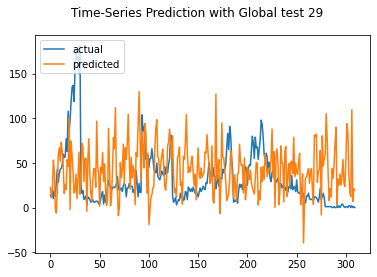

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 42.068
Test RMSE: 49.355
Test sMAPE: 96.875
Test R Squared: -1.455
{'mae': 42.06815226770217, 'rmse': 49.35544471455482, 'smape': 96.87506751317815, 'r2': -1.4553028808248802}


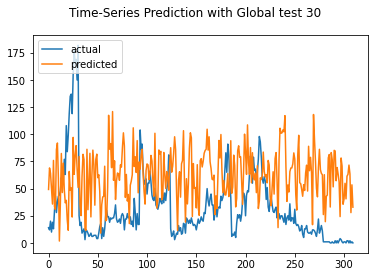

Test MAE: 42.937
Test RMSE: 49.378
Test sMAPE: 98.458
Test R Squared: -1.458
{'mae': 42.93722405587473, 'rmse': 49.37784472113251, 'smape': 98.45844567112945, 'r2': -1.4575320687745732}


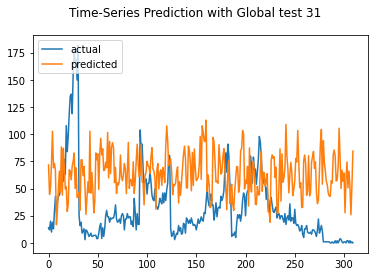

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 35.639
Test RMSE: 44.690
Test sMAPE: 99.942
Test R Squared: -1.013
{'mae': 35.63895770407492, 'rmse': 44.689857269817125, 'smape': 99.94183941855744, 'r2': -1.0130421559326446}


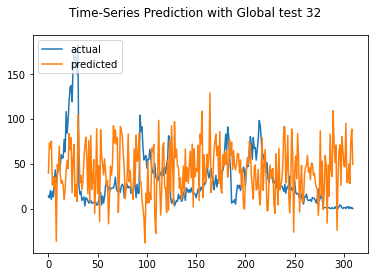

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 41.706
Test RMSE: 50.274
Test sMAPE: 95.609
Test R Squared: -1.548
{'mae': 41.70617270969576, 'rmse': 50.274003880950694, 'smape': 95.60943998397745, 'r2': -1.5475451114395726}


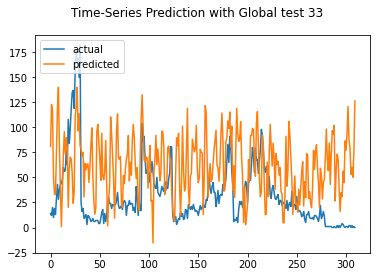

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 38.169
Test RMSE: 47.781
Test sMAPE: 105.010
Test R Squared: -1.301
{'mae': 38.16949238411842, 'rmse': 47.780837731015225, 'smape': 105.01027971261102, 'r2': -1.301136887300507}


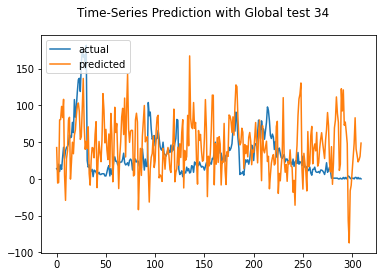

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 37.515
Test RMSE: 47.053
Test sMAPE: 92.645
Test R Squared: -1.232
{'mae': 37.51495667484499, 'rmse': 47.053445363904814, 'smape': 92.64497324263576, 'r2': -1.2316073980049653}


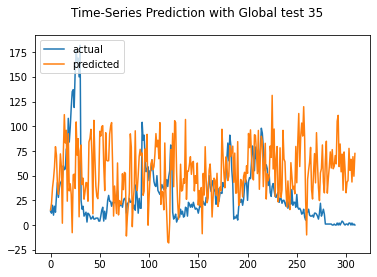

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 42.612
Test RMSE: 51.026
Test sMAPE: 99.013
Test R Squared: -1.624
{'mae': 42.612060510727666, 'rmse': 51.02568628414087, 'smape': 99.01260062898577, 'r2': -1.624294943719656}


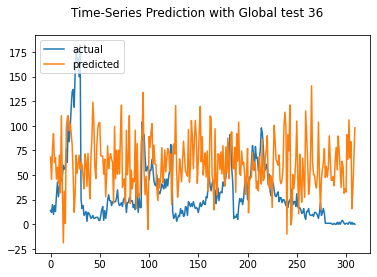

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 43.376
Test RMSE: 51.894
Test sMAPE: 101.783
Test R Squared: -1.714
{'mae': 43.376375451780135, 'rmse': 51.89356242530884, 'smape': 101.78289529507414, 'r2': -1.7143253668125378}


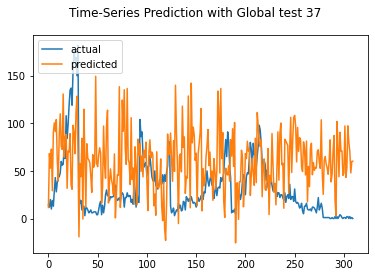

Test MAE: 36.541
Test RMSE: 43.153
Test sMAPE: 92.813
Test R Squared: -0.877
{'mae': 36.54142908050168, 'rmse': 43.153314142642316, 'smape': 92.81254677707827, 'r2': -0.8769955549770954}


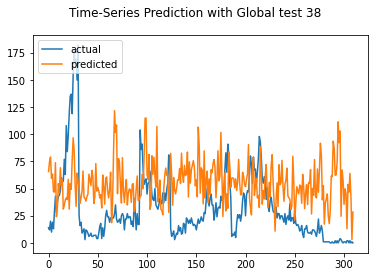

Test MAE: 64.069
Test RMSE: 78.630
Test sMAPE: 117.525
Test R Squared: -5.232
{'mae': 64.06875071794757, 'rmse': 78.63022926855392, 'smape': 117.52479359092409, 'r2': -5.23180734056508}


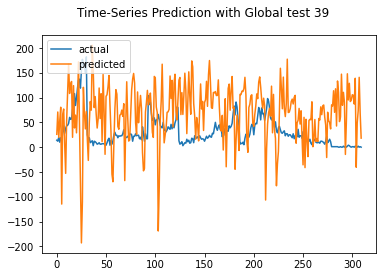

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 40.357
Test RMSE: 48.680
Test sMAPE: 98.749
Test R Squared: -1.389
{'mae': 40.35707595559858, 'rmse': 48.679905022577614, 'smape': 98.74910941854513, 'r2': -1.388550231264571}


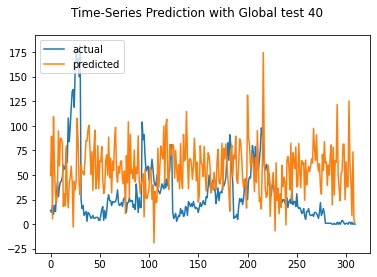

Test MAE: 40.890
Test RMSE: 46.910
Test sMAPE: 95.660
Test R Squared: -1.218
{'mae': 40.89002126878308, 'rmse': 46.909515145649465, 'smape': 95.66029981121369, 'r2': -1.217975899189327}


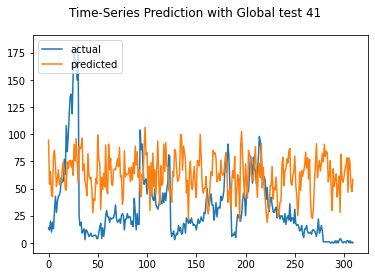

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 37.993
Test RMSE: 45.710
Test sMAPE: 95.127
Test R Squared: -1.106
{'mae': 37.99347150268093, 'rmse': 45.70984057223396, 'smape': 95.12662717283544, 'r2': -1.1059805097209292}


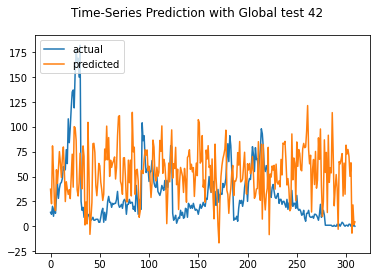

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 35.846
Test RMSE: 43.041
Test sMAPE: 91.373
Test R Squared: -0.867
{'mae': 35.84625988929503, 'rmse': 43.04132392745515, 'smape': 91.37255256428952, 'r2': -0.8672659487498047}


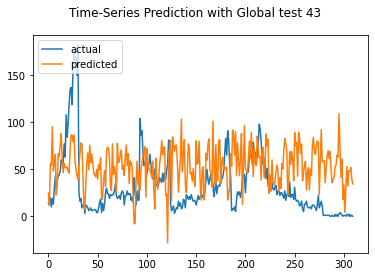

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 34.697
Test RMSE: 42.010
Test sMAPE: 87.962
Test R Squared: -0.779
{'mae': 34.69694083121516, 'rmse': 42.00959111398077, 'smape': 87.96165890200413, 'r2': -0.7788193435848916}


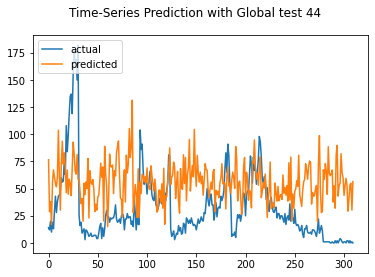

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 42.855
Test RMSE: 52.679
Test sMAPE: 103.349
Test R Squared: -1.797
{'mae': 42.85474987183848, 'rmse': 52.67857514159367, 'smape': 103.3492030532731, 'r2': -1.79706767120082}


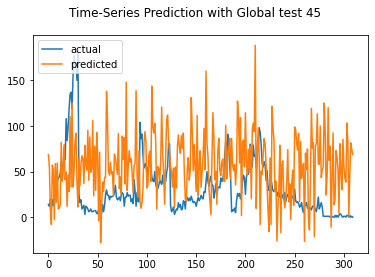

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 38.232
Test RMSE: 46.008
Test sMAPE: 95.144
Test R Squared: -1.134
{'mae': 38.232170461839246, 'rmse': 46.00797268645486, 'smape': 95.14441876731382, 'r2': -1.1335416629826045}


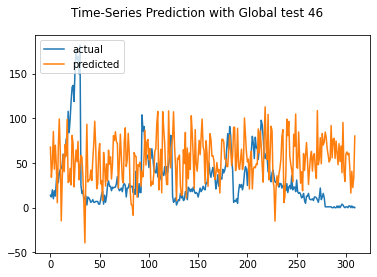

Test MAE: 37.087
Test RMSE: 43.090
Test sMAPE: 92.427
Test R Squared: -0.871
{'mae': 37.08658024572558, 'rmse': 43.08985081458377, 'smape': 92.4272288659259, 'r2': -0.8714788156504929}


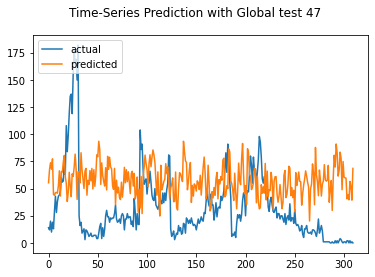

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 36.041
Test RMSE: 42.960
Test sMAPE: 94.229
Test R Squared: -0.860
{'mae': 36.04050487164529, 'rmse': 42.95977527702896, 'smape': 94.22925448601333, 'r2': -0.8601969856478051}


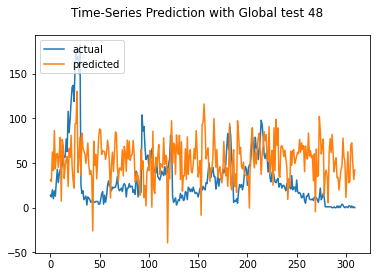

Test MAE: 41.038
Test RMSE: 47.950
Test sMAPE: 96.580
Test R Squared: -1.317
{'mae': 41.03840024163646, 'rmse': 47.949798029068724, 'smape': 96.5797124740966, 'r2': -1.3174400005201976}


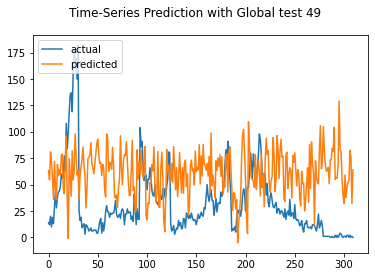

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 36.590
Test RMSE: 49.411
Test sMAPE: 123.549
Test R Squared: -1.461
{'mae': 36.589892518904904, 'rmse': 49.41055291745563, 'smape': 123.54914430633981, 'r2': -1.4607889166348742}


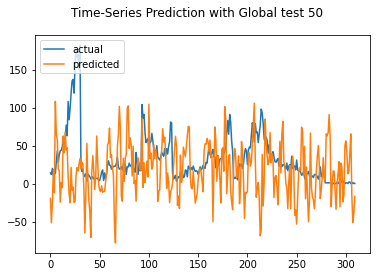

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 38.710
Test RMSE: 49.672
Test sMAPE: 105.667
Test R Squared: -1.487
{'mae': 38.709910783363924, 'rmse': 49.67246059098084, 'smape': 105.6665729878917, 'r2': -1.4869455812636634}


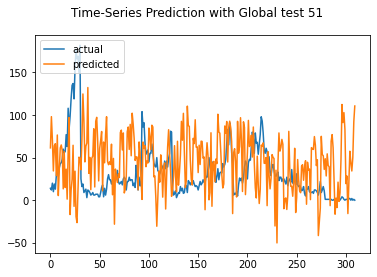

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 35.548
Test RMSE: 44.614
Test sMAPE: 92.213
Test R Squared: -1.006
{'mae': 35.54801474271282, 'rmse': 44.614296299625394, 'smape': 92.21348666946764, 'r2': -1.0062406650753317}


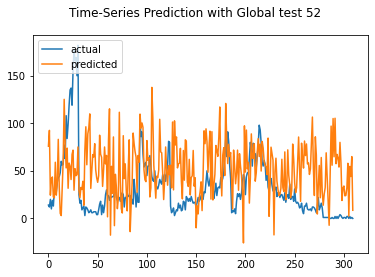

Test MAE: 41.563
Test RMSE: 47.283
Test sMAPE: 96.840
Test R Squared: -1.253
{'mae': 41.56275857494723, 'rmse': 47.28274773711199, 'smape': 96.84032041162327, 'r2': -1.2534106779276097}


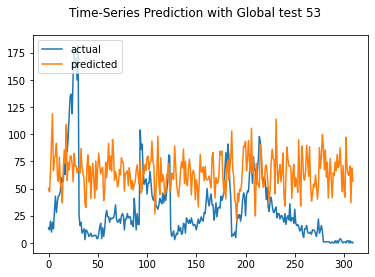

Test MAE: 39.405
Test RMSE: 46.379
Test sMAPE: 94.887
Test R Squared: -1.168
{'mae': 39.40472011258525, 'rmse': 46.379011458876015, 'smape': 94.88736631921232, 'r2': -1.1680930128523674}


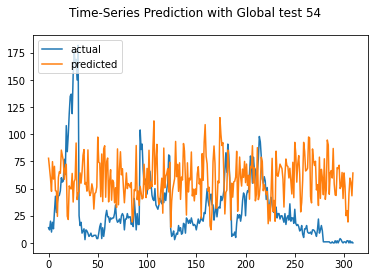

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 31.605
Test RMSE: 40.188
Test sMAPE: 89.866
Test R Squared: -0.628
{'mae': 31.60529962518523, 'rmse': 40.18771264169134, 'smape': 89.86644006698029, 'r2': -0.6278767143327637}


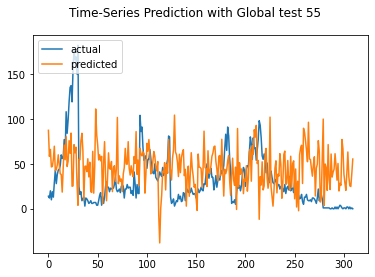

Test MAE: 38.290
Test RMSE: 44.034
Test sMAPE: 94.386
Test R Squared: -0.954
{'mae': 38.290256949393985, 'rmse': 44.03448856927496, 'smape': 94.38643139374548, 'r2': -0.9544332739699266}


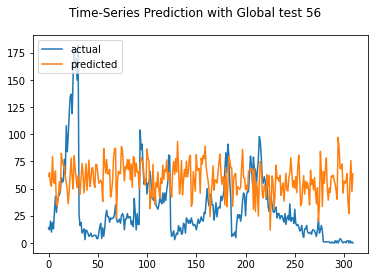

Test MAE: 40.657
Test RMSE: 46.872
Test sMAPE: 95.814
Test R Squared: -1.214
{'mae': 40.65743122716104, 'rmse': 46.872133583240874, 'smape': 95.81350894343089, 'r2': -1.2144423572737142}


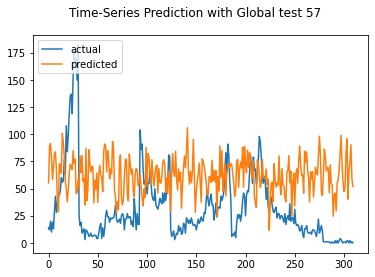

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 34.615
Test RMSE: 43.637
Test sMAPE: 104.436
Test R Squared: -0.919
{'mae': 34.61496277143878, 'rmse': 43.63732542357821, 'smape': 104.43614475830802, 'r2': -0.9193367691015653}


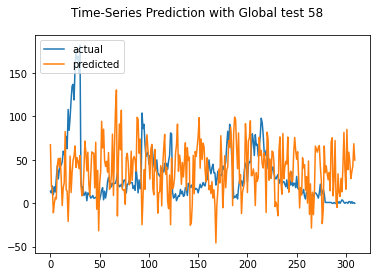

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 41.382
Test RMSE: 50.445
Test sMAPE: 104.897
Test R Squared: -1.565
{'mae': 41.381699792415866, 'rmse': 50.44535627395575, 'smape': 104.89717696672868, 'r2': -1.5649406575152867}


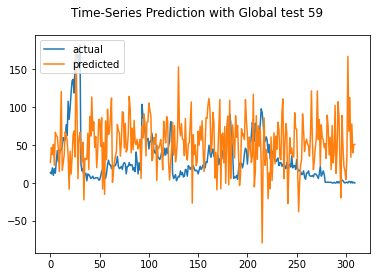

Test MAE: 57.028
Test RMSE: 66.070
Test sMAPE: 120.461
Test R Squared: -3.400
{'mae': 57.02847753667062, 'rmse': 66.07034518987736, 'smape': 120.46128899612104, 'r2': -3.3999534936449853}


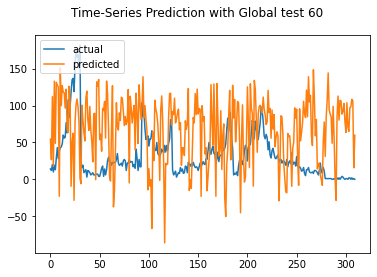

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 36.999
Test RMSE: 47.819
Test sMAPE: 102.129
Test R Squared: -1.305
{'mae': 36.99942046903795, 'rmse': 47.81856669901386, 'smape': 102.12879715861038, 'r2': -1.304772394820234}


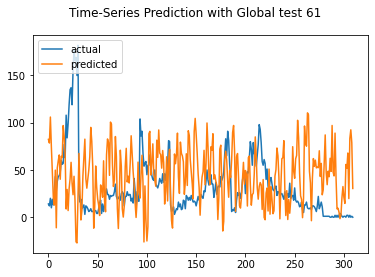

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 41.620
Test RMSE: 51.937
Test sMAPE: 101.193
Test R Squared: -1.719
{'mae': 41.620196241621045, 'rmse': 51.93710686998784, 'smape': 101.19266081838258, 'r2': -1.718882517028801}


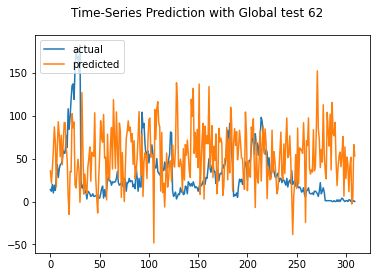

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 33.956
Test RMSE: 44.092
Test sMAPE: 104.366
Test R Squared: -0.960
{'mae': 33.95600794697962, 'rmse': 44.09234599451392, 'smape': 104.36649198865092, 'r2': -0.9595725531245582}


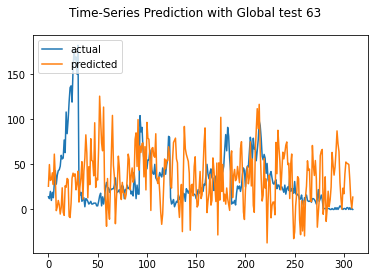

Test MAE: 38.588
Test RMSE: 45.125
Test sMAPE: 93.648
Test R Squared: -1.052
{'mae': 38.587972493325516, 'rmse': 45.12536893330812, 'smape': 93.64841485290242, 'r2': -1.0524683352567408}


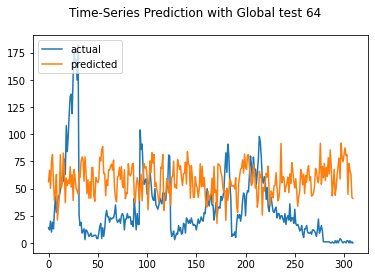

Test MAE: 41.024
Test RMSE: 46.410
Test sMAPE: 97.019
Test R Squared: -1.171
{'mae': 41.02407527431365, 'rmse': 46.41017055930373, 'smape': 97.01864026325667, 'r2': -1.1710071983438182}


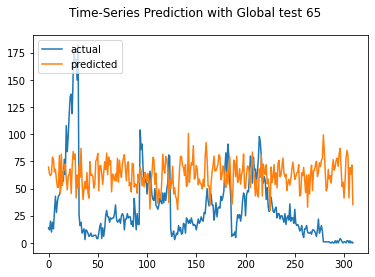

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 44.173
Test RMSE: 53.253
Test sMAPE: 104.749
Test R Squared: -1.858
{'mae': 44.17283369841114, 'rmse': 53.25297600241499, 'smape': 104.74942815035402, 'r2': -1.8583980078000226}


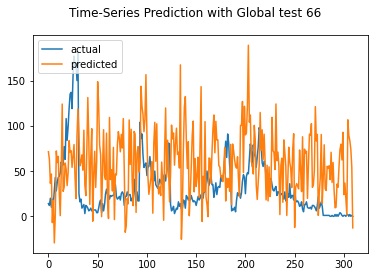

Test MAE: 47.517
Test RMSE: 53.828
Test sMAPE: 104.314
Test R Squared: -1.920
{'mae': 47.51669089140431, 'rmse': 53.827508130629916, 'smape': 104.31415896691635, 'r2': -1.9204077006644904}


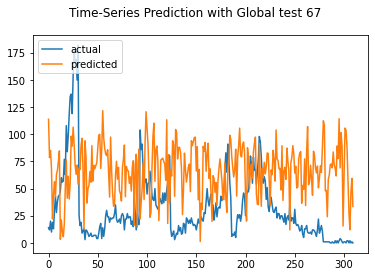

Test MAE: 37.821
Test RMSE: 44.963
Test sMAPE: 93.571
Test R Squared: -1.038
{'mae': 37.820545013489266, 'rmse': 44.963007760859774, 'smape': 93.57113635563039, 'r2': -1.0377253349453324}


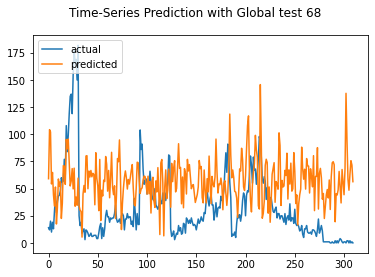

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 39.072
Test RMSE: 48.236
Test sMAPE: 98.038
Test R Squared: -1.345
{'mae': 39.07154418018556, 'rmse': 48.236103091145715, 'smape': 98.03755123129375, 'r2': -1.3451971829185632}


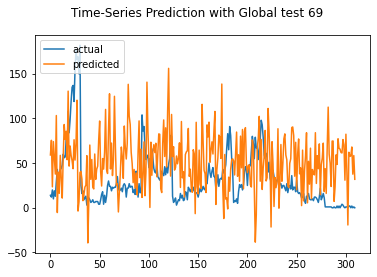

Test MAE: 40.541
Test RMSE: 48.233
Test sMAPE: 94.658
Test R Squared: -1.345
{'mae': 40.54119994563441, 'rmse': 48.233026926546984, 'smape': 94.6578765968731, 'r2': -1.3448980715869019}


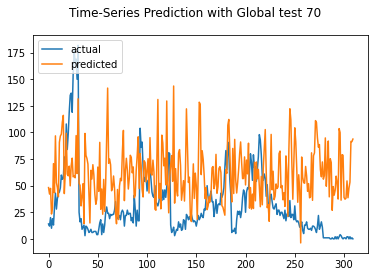

Test MAE: 34.957
Test RMSE: 40.960
Test sMAPE: 90.868
Test R Squared: -0.691
{'mae': 34.957019122954335, 'rmse': 40.96040433146875, 'smape': 90.86833750297814, 'r2': -0.6910770845803067}


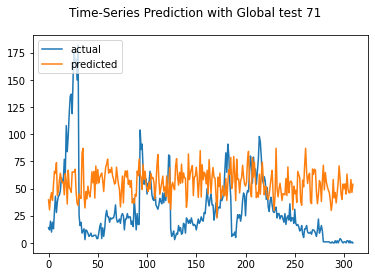

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 37.825
Test RMSE: 45.163
Test sMAPE: 94.239
Test R Squared: -1.056
{'mae': 37.82504264923834, 'rmse': 45.163359815692196, 'smape': 94.23883973821029, 'r2': -1.0559257211323065}


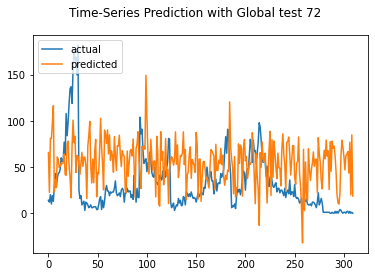

Test MAE: 43.584
Test RMSE: 49.089
Test sMAPE: 99.213
Test R Squared: -1.429
{'mae': 43.583851445105765, 'rmse': 49.088599944901084, 'smape': 99.2125210473085, 'r2': -1.4288250088468253}


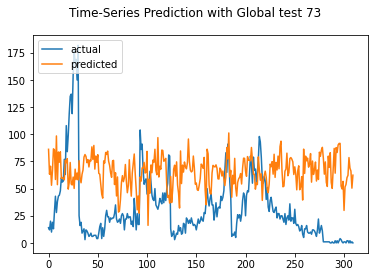

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 34.951
Test RMSE: 45.926
Test sMAPE: 106.982
Test R Squared: -1.126
{'mae': 34.950621252867485, 'rmse': 45.925549443524524, 'smape': 106.9818053236479, 'r2': -1.1259040344628426}


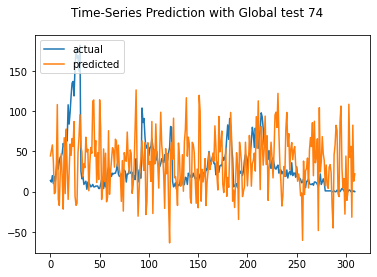

Test MAE: 38.367
Test RMSE: 44.155
Test sMAPE: 94.167
Test R Squared: -0.965
{'mae': 38.36748016111313, 'rmse': 44.15498345434683, 'smape': 94.1673371862679, 'r2': -0.9651440339900532}


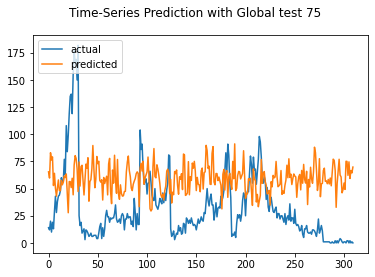

Test MAE: 43.061
Test RMSE: 49.059
Test sMAPE: 99.394
Test R Squared: -1.426
{'mae': 43.06074276124277, 'rmse': 49.05863932309451, 'smape': 99.3935116654267, 'r2': -1.425861106810824}


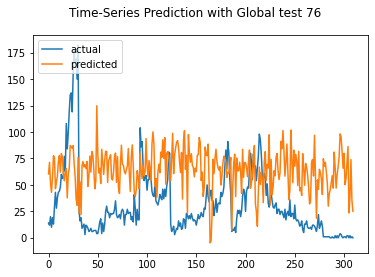

Test MAE: 46.631
Test RMSE: 55.669
Test sMAPE: 101.143
Test R Squared: -2.124
{'mae': 46.63108671595973, 'rmse': 55.66868513039028, 'smape': 101.14310250248226, 'r2': -2.123610410976207}


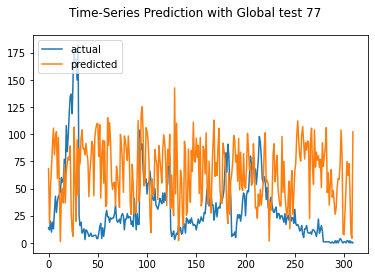

Test MAE: 55.799
Test RMSE: 62.338
Test sMAPE: 111.063
Test R Squared: -2.917
{'mae': 55.79854807642199, 'rmse': 62.33791854980854, 'smape': 111.06252108630274, 'r2': -2.916873347782982}


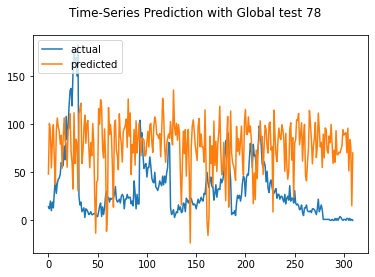

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 35.534
Test RMSE: 43.442
Test sMAPE: 99.427
Test R Squared: -0.902
{'mae': 35.53399453220829, 'rmse': 43.44214299522387, 'smape': 99.42687156851197, 'r2': -0.902205425702026}


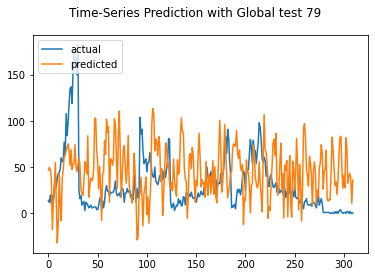

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 38.411
Test RMSE: 47.517
Test sMAPE: 94.163
Test R Squared: -1.276
{'mae': 38.41089022649873, 'rmse': 47.5174920972679, 'smape': 94.16267886459983, 'r2': -1.2758412080332362}


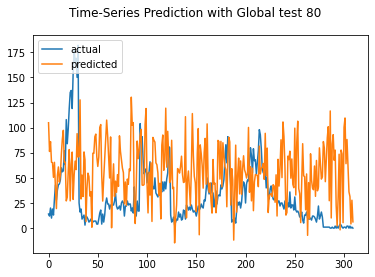

Test MAE: 46.769
Test RMSE: 52.713
Test sMAPE: 102.058
Test R Squared: -1.801
{'mae': 46.76896201410601, 'rmse': 52.712628495273364, 'smape': 102.05817962353201, 'r2': -1.8006850933047849}


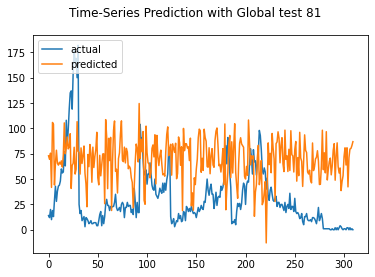

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 36.620
Test RMSE: 46.095
Test sMAPE: 96.806
Test R Squared: -1.142
{'mae': 36.61984523034865, 'rmse': 46.095031165254284, 'smape': 96.8058903085888, 'r2': -1.1416236807962479}


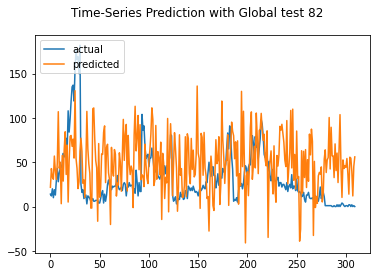

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 37.469
Test RMSE: 49.657
Test sMAPE: 126.380
Test R Squared: -1.485
{'mae': 37.46891619043966, 'rmse': 49.65726137409758, 'smape': 126.37999521732735, 'r2': -1.4854238590986744}


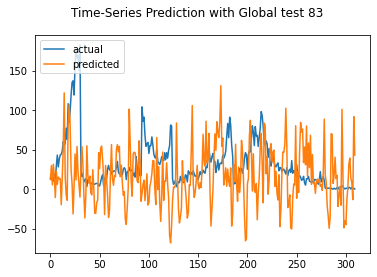

Test MAE: 33.284
Test RMSE: 44.069
Test sMAPE: 95.675
Test R Squared: -0.958
{'mae': 33.28416892905389, 'rmse': 44.06918197820864, 'smape': 95.67477073013102, 'r2': -0.9575141619791143}


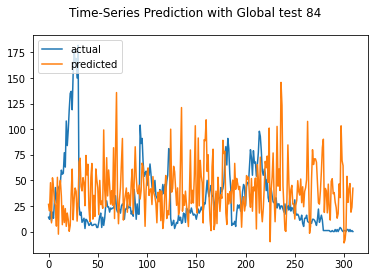

Test MAE: 48.138
Test RMSE: 54.665
Test sMAPE: 102.385
Test R Squared: -2.012
{'mae': 48.13846313568853, 'rmse': 54.66521265859327, 'smape': 102.38528050997536, 'r2': -2.01201422335683}


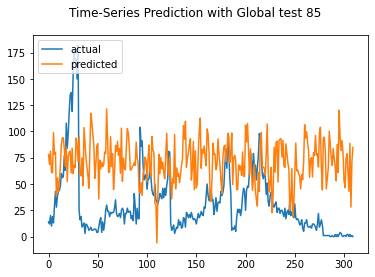

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 40.482
Test RMSE: 48.867
Test sMAPE: 97.743
Test R Squared: -1.407
{'mae': 40.48183367540759, 'rmse': 48.8672530951248, 'smape': 97.74314191272663, 'r2': -1.4069706197542744}


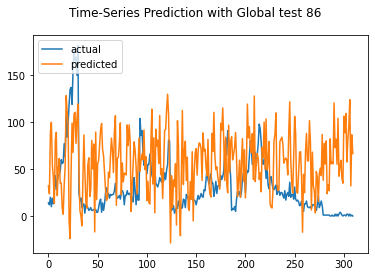

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 40.348
Test RMSE: 49.858
Test sMAPE: 99.702
Test R Squared: -1.506
{'mae': 40.3482072803282, 'rmse': 49.85771964584456, 'smape': 99.70200259393658, 'r2': -1.5055308638599114}


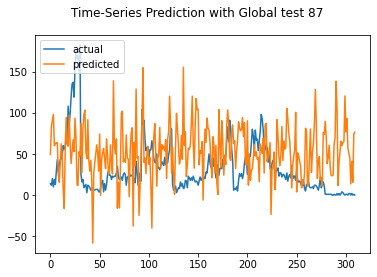

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 41.051
Test RMSE: 48.311
Test sMAPE: 96.847
Test R Squared: -1.352
{'mae': 41.05149272161145, 'rmse': 48.310591168121455, 'smape': 96.846973700291, 'r2': -1.3524458658780265}


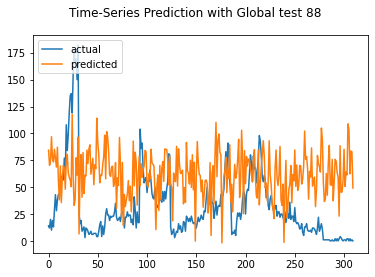

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 35.807
Test RMSE: 46.604
Test sMAPE: 114.727
Test R Squared: -1.189
{'mae': 35.806928246348136, 'rmse': 46.60433482076951, 'smape': 114.72703140938397, 'r2': -1.1892106988698403}


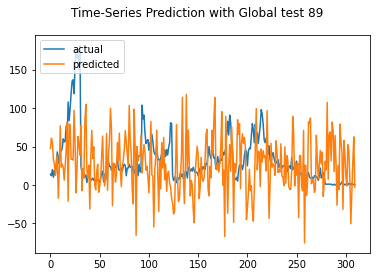

Test MAE: 51.999
Test RMSE: 64.713
Test sMAPE: 124.126
Test R Squared: -3.221
{'mae': 51.99900557889092, 'rmse': 64.7129023204556, 'smape': 124.12566744045358, 'r2': -3.2210130077660324}


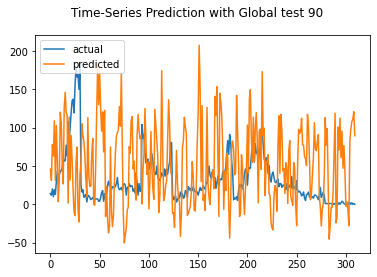

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 42.075
Test RMSE: 50.121
Test sMAPE: 100.927
Test R Squared: -1.532
{'mae': 42.07530721502919, 'rmse': 50.120531854220296, 'smape': 100.92714539243222, 'r2': -1.5320150119265432}


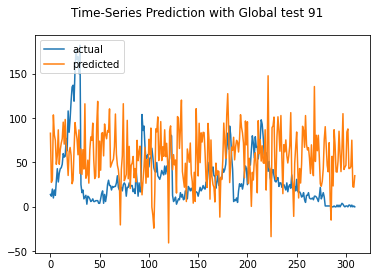

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 37.829
Test RMSE: 45.255
Test sMAPE: 93.869
Test R Squared: -1.064
{'mae': 37.82943354114409, 'rmse': 45.254576489565856, 'smape': 93.86900751208478, 'r2': -1.0642388355326542}


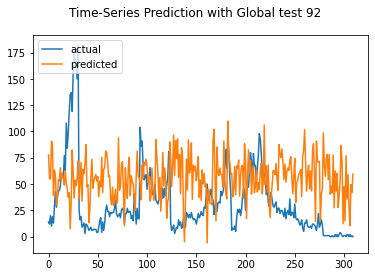

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 37.565
Test RMSE: 47.647
Test sMAPE: 102.920
Test R Squared: -1.288
{'mae': 37.56507290082593, 'rmse': 47.6470977606271, 'smape': 102.9196904442486, 'r2': -1.2882730160274156}


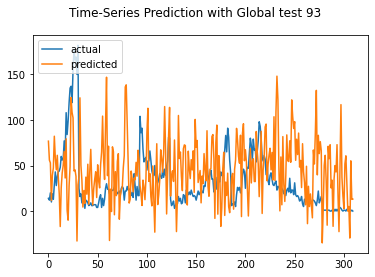

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 36.215
Test RMSE: 43.577
Test sMAPE: 92.466
Test R Squared: -0.914
{'mae': 36.21464605639058, 'rmse': 43.57699123311895, 'smape': 92.46565100715246, 'r2': -0.9140329804863061}


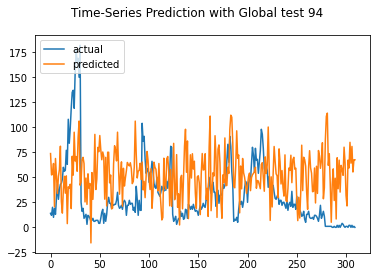

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.705
Test RMSE: 52.846
Test sMAPE: 102.555
Test R Squared: -1.815
{'mae': 41.7050100355379, 'rmse': 52.84567519697322, 'smape': 102.55528642991625, 'r2': -1.814840796549599}


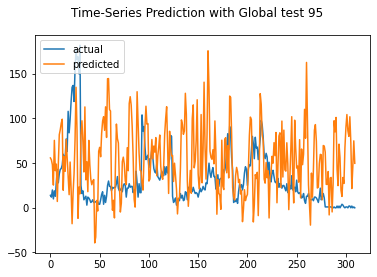

Test MAE: 43.133
Test RMSE: 51.104
Test sMAPE: 96.800
Test R Squared: -1.632
{'mae': 43.13320894241333, 'rmse': 51.10406429323852, 'smape': 96.80031832758064, 'r2': -1.632363232487125}


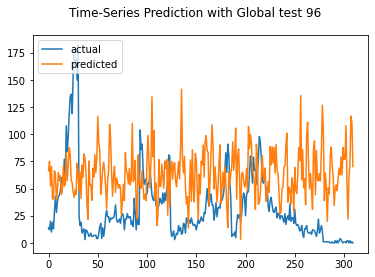

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 36.500
Test RMSE: 43.384
Test sMAPE: 91.262
Test R Squared: -0.897
{'mae': 36.49963700329104, 'rmse': 43.38397592105584, 'smape': 91.26156259714928, 'r2': -0.8971149010808277}


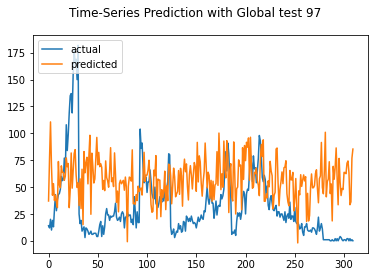

Test MAE: 42.703
Test RMSE: 50.462
Test sMAPE: 97.350
Test R Squared: -1.567
{'mae': 42.70252302846601, 'rmse': 50.46231628196625, 'smape': 97.34979728754953, 'r2': -1.5666656419348528}


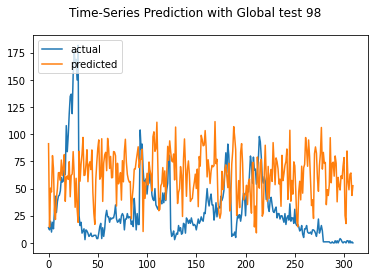

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 35.104
Test RMSE: 44.035
Test sMAPE: 101.000
Test R Squared: -0.955
{'mae': 35.10385972915158, 'rmse': 44.0353158058824, 'smape': 101.00012300022703, 'r2': -0.9545067070443205}


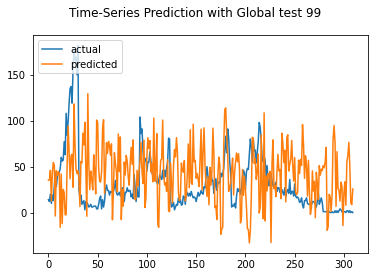

rmse : average=48.236, std=5.521
mae : average=39.892, std=5.131
smape : average=99.456, std=7.786
r2 : average=-1.376, std=0.614


([48.236015788271025, 5.521428706483315],
 [39.89226307317711, 5.131460693875689],
 [99.4555357873705, 7.786252480140302],
 [-1.3759169469096841, 0.61431474166957])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')